In [320]:
import sys
sys.path.append(".")

In [321]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pylab as plt
from pathlib import Path
from tensorflow.keras import layers

#from PlayingCardsGenerator import CardsDataGenerator
import datetime

In [322]:
model_name_it = "Outputs/Efficient_net_B0_it_52.h5"

In [323]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [324]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

In [325]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

In [326]:
def scheduler(epoch, lr):
    if epoch%30 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [327]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [328]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [329]:
log_dir = "Outputs/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [411]:
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "rotation_range":90,\
              "width_shift_range":0.2,\
              "height_shift_range":0.2, \
              "shear_range":0.4, \
              "zoom_range":0.4,\
              "vertical_flip":True,\
              "brightness_range": (0.1, 2)}

In [412]:
generator = ImageDataGenerator(**gen_params, validation_split=0.2,  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [413]:
bs = 16 # batch size

In [414]:
path = Path("dataset/")

In [415]:
img_height = 224
img_width = 224

In [416]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [417]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    shuffle = True,
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as training data

Found 24952 images belonging to 52 classes.


In [418]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as validation data

Found 6206 images belonging to 52 classes.


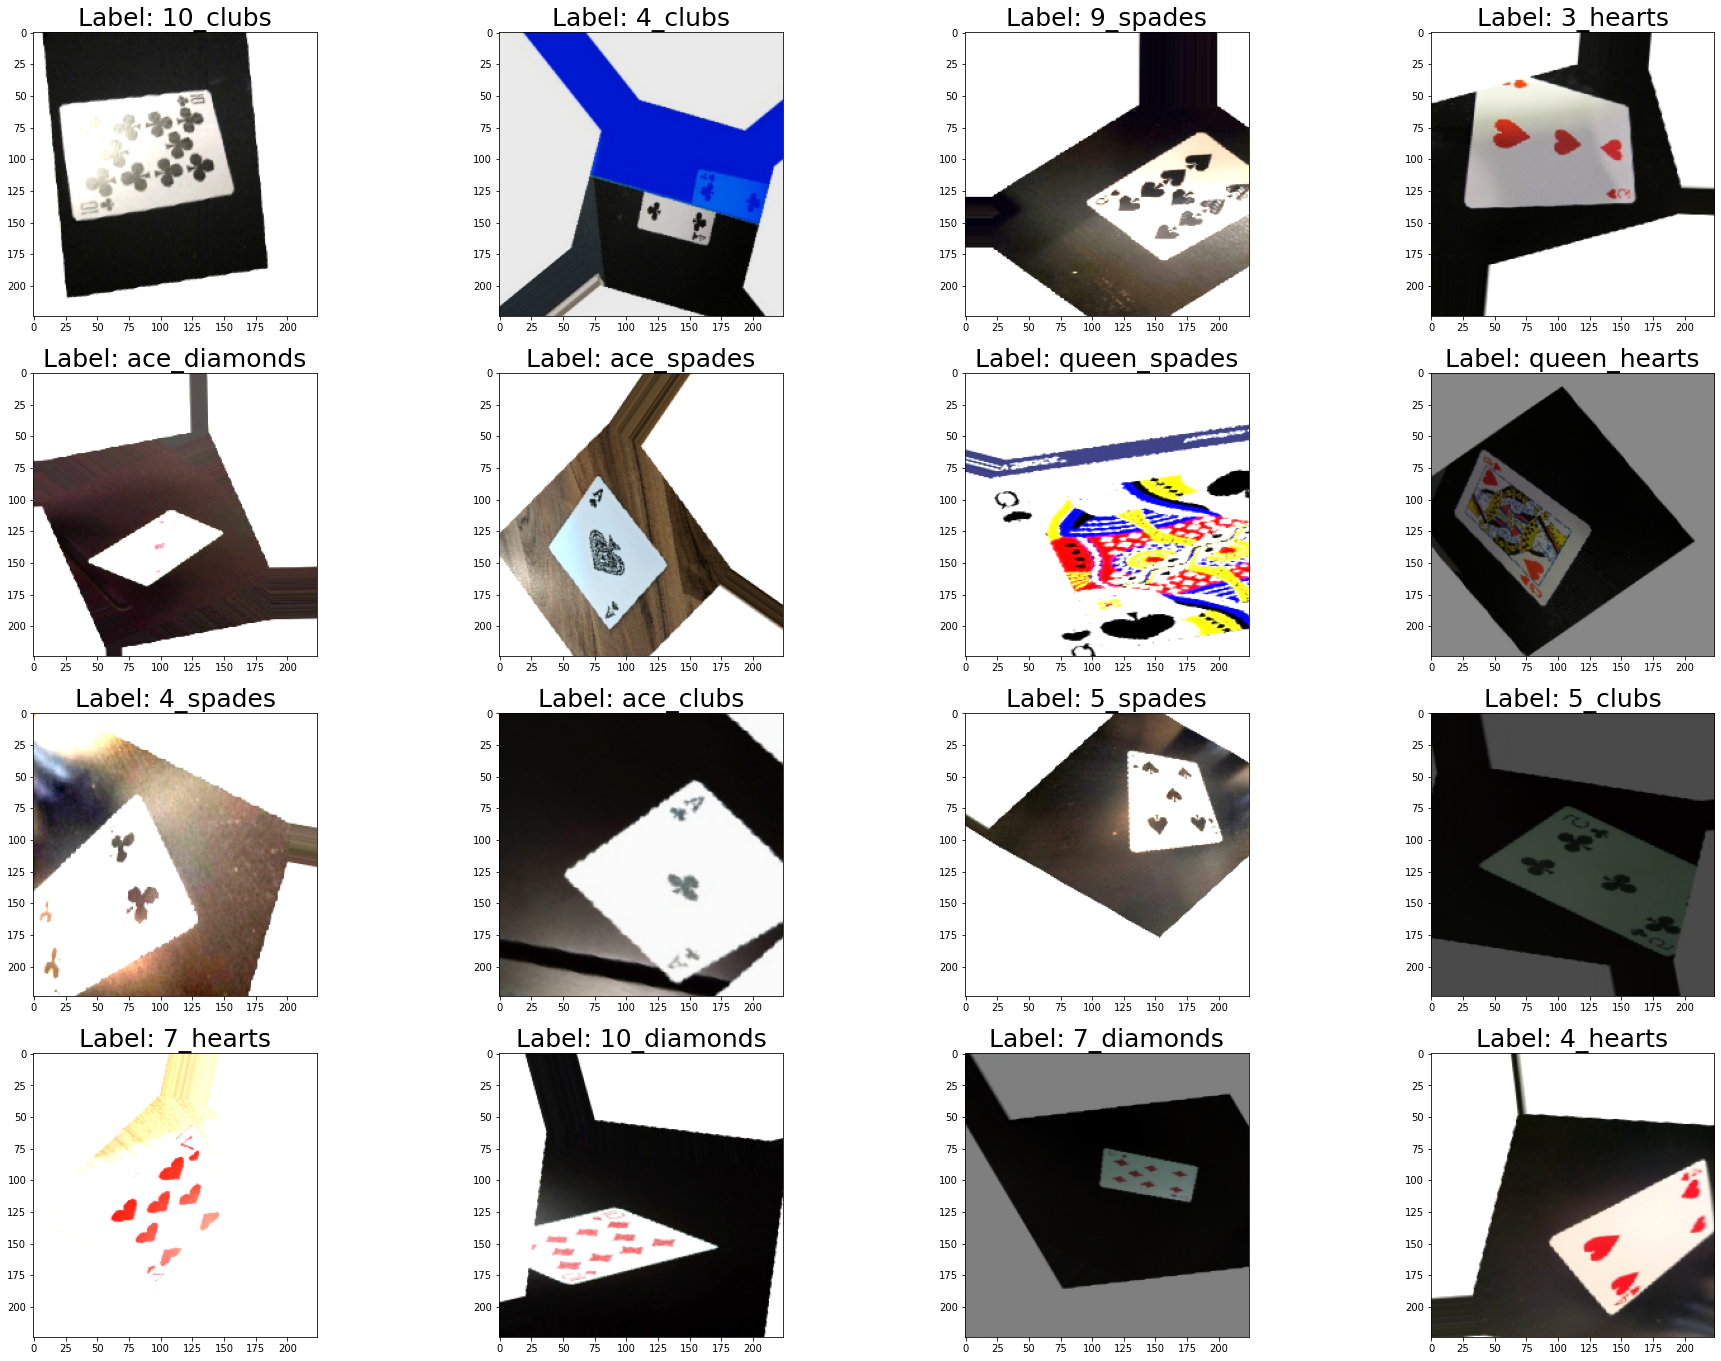

In [419]:
#Exploratory data analysis
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_generator.__getitem__(0)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [420]:
# Defining the model

trainable_flag = True
include_top_flag = False
weigths_value = 'imagenet'

if trainable_flag:
    include_top_flag = True
    weigths_value = None
else:
    include_top_flag = False
    weigths_value = 'imagenet'    


In [421]:
print(weigths_value)
print(include_top_flag)
print(trainable_flag)

base_model = tf.keras.applications.EfficientNetB0(
    weights=weigths_value, 
    include_top=include_top_flag,
    classes=len(classes_names))

None
True
True


In [387]:
inputs = layers.Input(shape=(img_height,img_width,3))
outputs = tf.keras.applications.EfficientNetB0(include_top=include_top_flag, weights=weigths_value,drop_connect_rate=0.3, classes=len(classes_names))(inputs)
model = tf.keras.Model( inputs,  outputs)

In [388]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________
None


In [422]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), #
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [390]:
model = tf.keras.models.load_model(model_name_it)
model.summary()
#model.get_weights()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________


In [143]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 1e-4)

In [147]:
history_it = model.fit(train_generator, epochs=1000, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [monitor_it,early_stop,lr_schedule,tensorboard_callback])

Epoch 1/1000
1560/1560 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9489
Epoch 1: val_loss did not improve from 0.28560
1560/1560 [==============================] - 399s 255ms/step - loss: 0.1556 - accuracy: 0.9489 - val_loss: 0.3940 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 2/1000
1560/1560 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9505
Epoch 2: val_loss did not improve from 0.28560
1560/1560 [==============================] - 396s 254ms/step - loss: 0.1490 - accuracy: 0.9505 - val_loss: 0.3058 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 3/1000
1560/1560 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9523
Epoch 3: val_loss improved from 0.28560 to 0.20209, saving model to Outputs\Efficient_net_B0_it_52.h5
1560/1560 [==============================] - 394s 253ms/step - loss: 0.1473 - accuracy: 0.9523 - val_loss: 0.2021 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 4/1000
1560/1560 [==============================

In [279]:
model.save('final_it_EfficientNetB0_52_9_percent.h5')
#np.save('efficientNetB0_history_96.npy',history_it.history)


In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [285]:
model = tf.keras.models.load_model(model_name_it)
model.summary()
#model.get_weights()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________


In [436]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 5e-4)

In [ ]:
history_ft = model.fit(train_generator, epochs=10, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [monitor_it,early_stop,lr_schedule,tensorboard_callback])

Epoch 1/10
1560/1560 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9294
Epoch 1: val_loss improved from 0.28485 to 0.24108, saving model to Outputs\Efficient_net_B0_it_52.h5
1560/1560 [==============================] - 407s 259ms/step - loss: 0.2287 - accuracy: 0.9294 - val_loss: 0.2411 - val_accuracy: 0.9268 - lr: 5.0000e-04
Epoch 2/10
 567/1560 [=========>....................] - ETA: 4:01 - loss: 0.2007 - accuracy: 0.9384

In [397]:
model = tf.keras.models.load_model(model_name_it)
model.summary()
#model.get_weights()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
%tensorboard --logdir 'Outputs/logs/fit'

In [ ]:
##!jupyter nbconvert --to script train-talc.ipynb

[NbConvertApp] Converting notebook train-talc.ipynb to script
[NbConvertApp] Writing 5159 bytes to train-talc.py


In [425]:
testgen=ImageDataGenerator()
test_generator = generator.flow_from_directory(
    directory = 'dataset_test',
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    shuffle=False,
    subset='validation',
    interpolation="nearest",
    classes=classes_names) # set as validation data
filenames = test_generator.filenames
nb_samples = len(filenames)

Found 1542 images belonging to 52 classes.


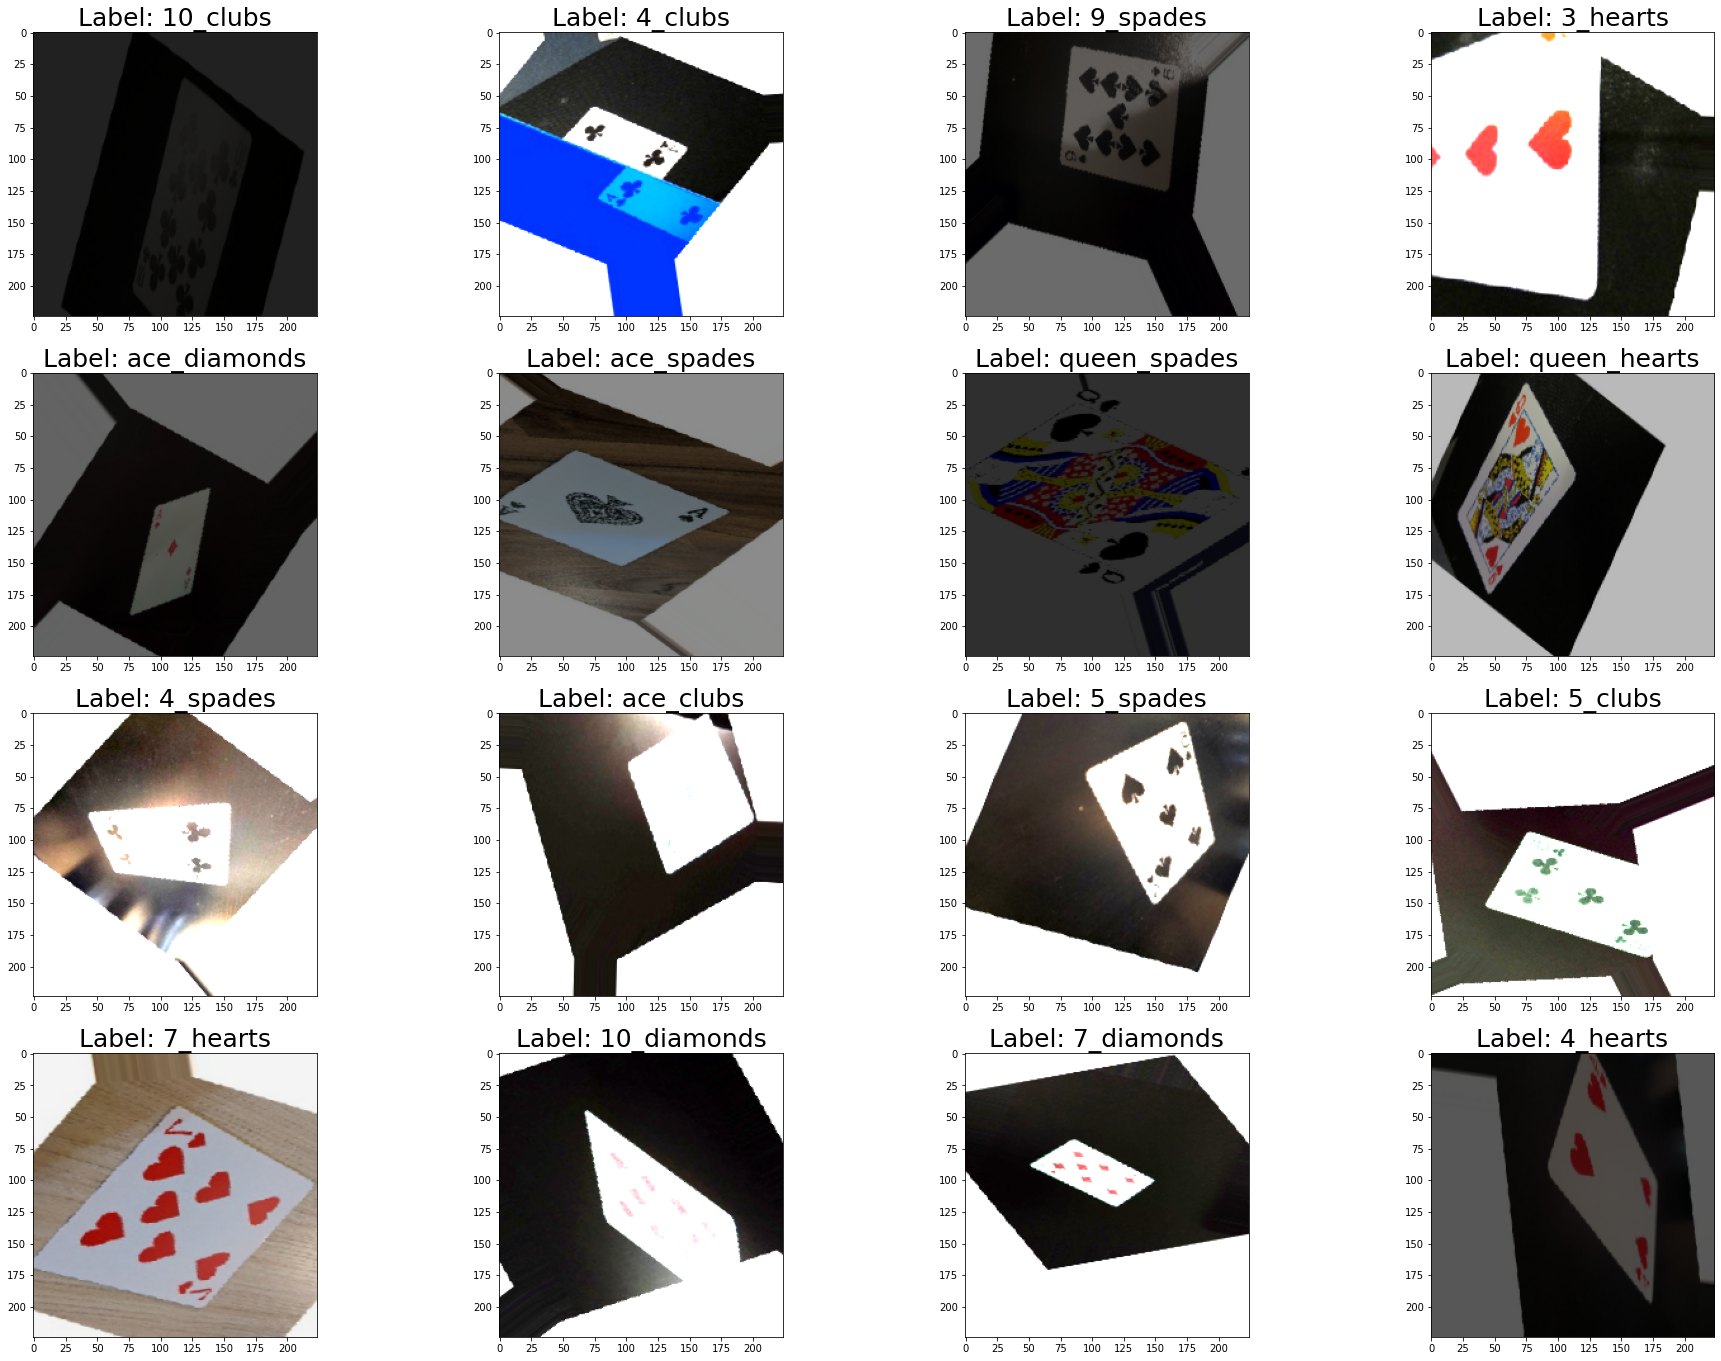

In [426]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_generator.__getitem__(0)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [ ]:
predict = model.predict(test_generator, verbose = 1)


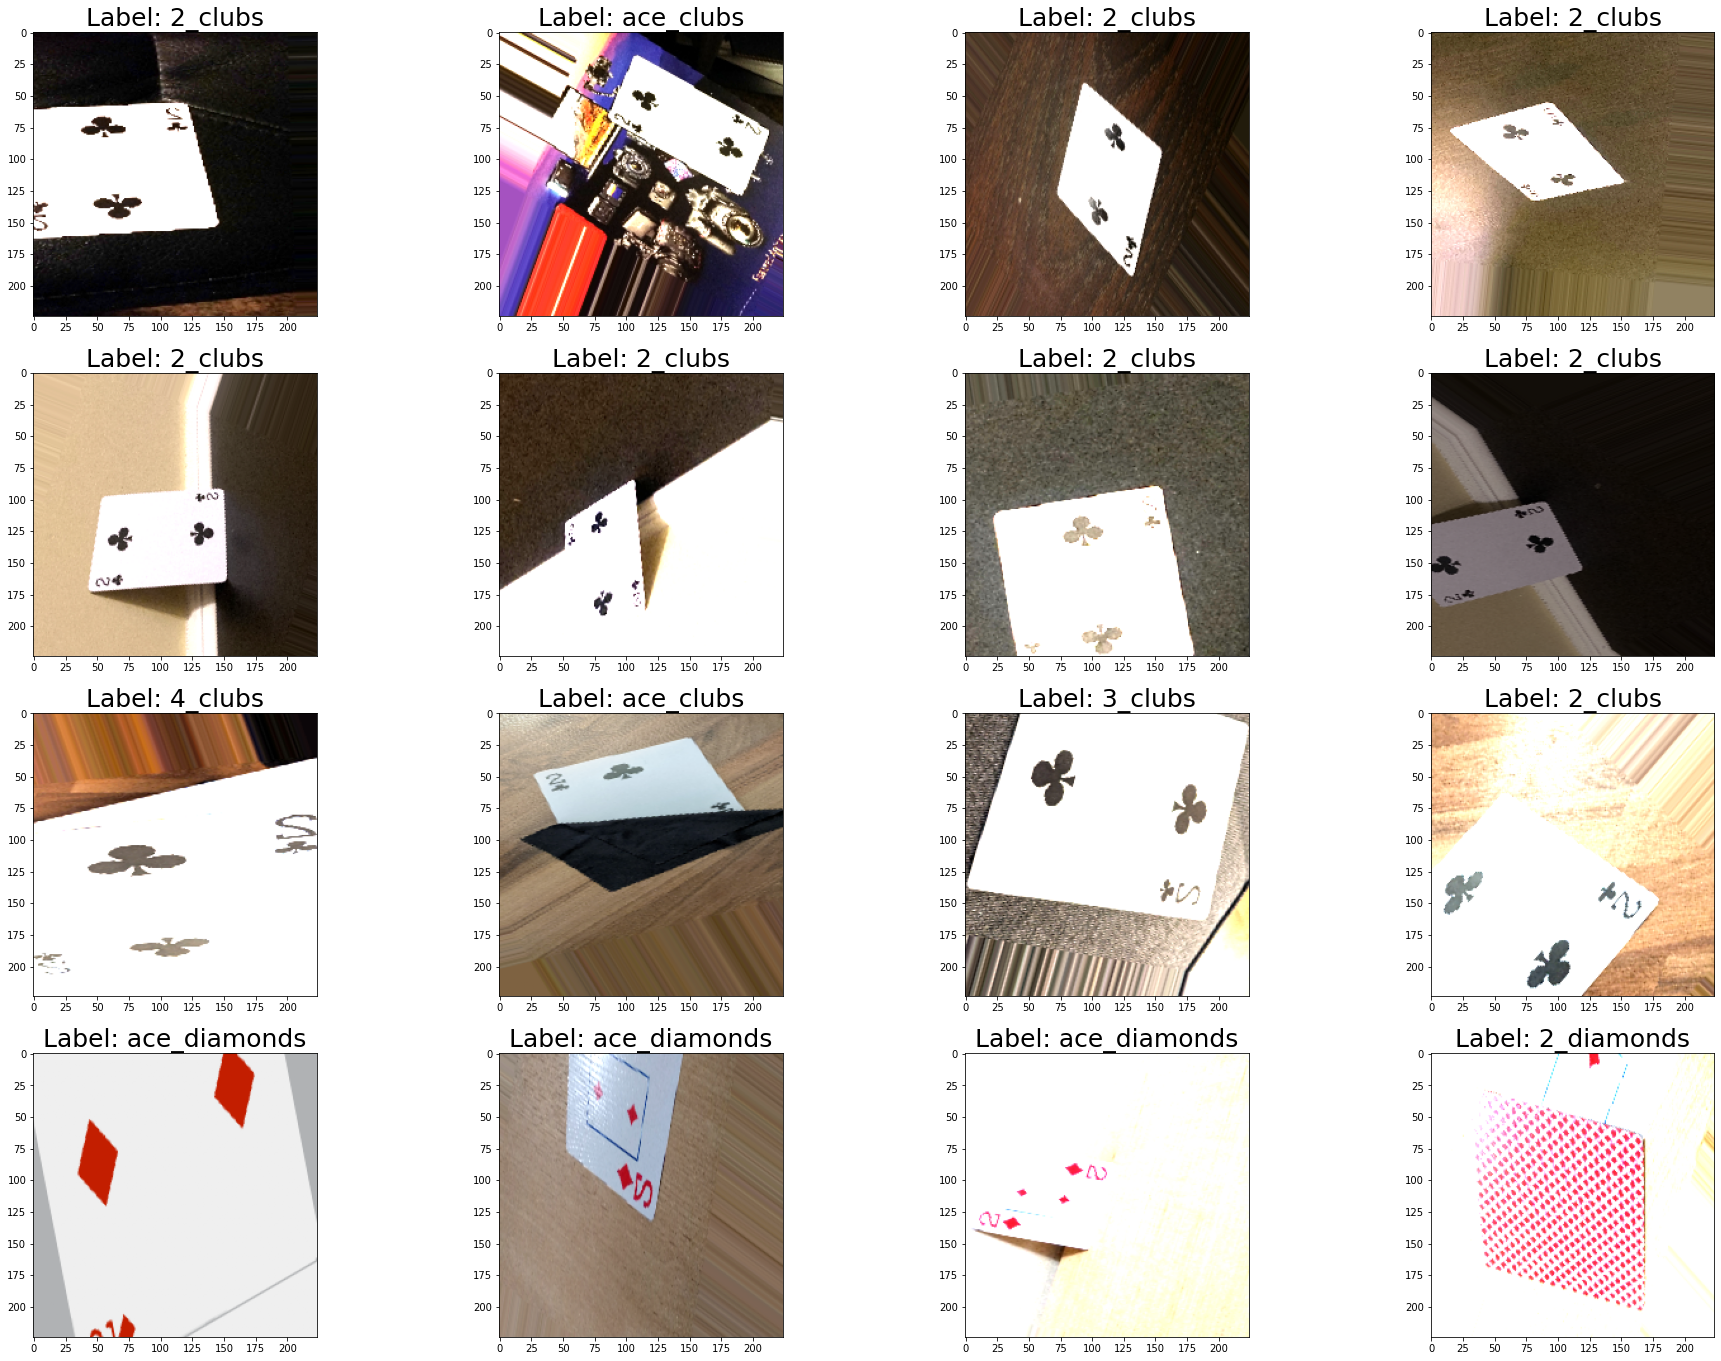

In [427]:
plt.figure(figsize = (32,24))
batch_num = 1
Xbatch,Ybatch = test_generator.__getitem__(batch_num)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(predict[ii +(batch_num*bs)].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()


In [429]:
predict1= model.evaluate(test_generator, verbose = 1)


97/97 [==============================] - 54s 542ms/step - loss: 0.4896 - accuracy: 0.8599


In [430]:
import pandas as pd
#
pred_num  = np.max(predict,axis = 1)
pred_idx = (np.argmax(predict,axis = 1)).astype(int).transpose()
pred_class = [classes_names[i] for i in pred_idx]
df = pd.DataFrame(data=pred_idx,columns= ['idx'])
df['pred_class'] = pred_num
df['pred_num'] = pred_class
df['file_name'] = filenames

In [431]:
df.head(50)

idx  pred_class       pred_num                      file_name
0     0    0.884673        2_clubs                 2_clubs\2C.png
1    36    0.555406      ace_clubs                2_clubs\C21.jpg
2     0    0.996069        2_clubs               2_clubs\C210.jpg
3     0    0.905390        2_clubs                2_clubs\C22.jpg
4     8    0.964014        4_clubs                2_clubs\C25.jpg
5     0    0.986501        2_clubs                2_clubs\C26.jpg
6     0    0.522728        2_clubs                2_clubs\C27.jpg
7    41    0.584648  jack_diamonds                2_clubs\C28.jpg
8     3    0.976960       2_spades                2_clubs\C29.png
9     0    0.784825        2_clubs      2_clubs\bg_ftdestetcw.jpg
10    0    0.984359        2_clubs      2_clubs\bg_grvcjmrgxa.jpg
11   36    0.624359      ace_clubs      2_clubs\bg_hfivvzchto.jpg
12    0    0.997321        2_clubs      2_clubs\bg_hfjonkrbxf.jpg
13    8    0.241647        4_clubs      2_clubs\bg_hqgambwsox.jpg
14    0    0.971329        2_clubs      2_clubs\bg_rttydbakaf.jpg
15    0    0.999914        2_clubs     2_clubs\cards-[C2]-001.jpg
16    0    0.999062        2_clubs     2_clubs\cards-[C2]-002.jpg
17   36    0.949429      ace_clubs     2_clubs\cards-[C2]-003.jpg
18    0    0.997983        2_clubs     2_clubs\cards-[C2]-004.jpg
19    0    0.944914        2_clubs      2_clubs\db_brtxueydhg.jpg
20    0    0.999829        2_clubs      2_clubs\db_ghwpggjpvx.jpg
21    0    0.884535        2_clubs      2_clubs\db_gzgkbgghew.jpg
22    0    0.980379        2_clubs      2_clubs\db_kynlszrvtm.jpg
23    0    0.999954        2_clubs      2_clubs\db_yxncbessuc.jpg
24    8    0.486311        4_clubs      2_clubs\jf_bfyuabnrhu.jpg
25   36    0.994152      ace_clubs      2_clubs\jf_dhqkuqwngj.jpg
26    4    0.833453        3_clubs      2_clubs\jf_flxuunyxhw.jpg
27    0    0.985472        2_clubs      2_clubs\jf_itnrbhycke.jpg
28   37    0.481841   ace_diamonds              2_diamonds\2D.png
29   37    0.857196   ace_diamonds   2_diamonds\bg_bhztvcsfcz.jpg
30   37    0.662262   ace_diamonds   2_diamonds\bg_fthxgjxfzw.jpg
31    1    0.874659     2_diamonds   2_diamonds\bg_glumutekzl.jpg
32    1    0.999870     2_diamonds   2_diamonds\bg_hfxiubbvbp.jpg
33    1    0.995193     2_diamonds   2_diamonds\bg_sijlxpqisj.jpg
34    1    0.992395     2_diamonds   2_diamonds\bg_wjuzrhahcw.jpg
35    1    0.987771     2_diamonds  2_diamonds\cards-[D2]-001.jpg
36    1    0.998489     2_diamonds  2_diamonds\cards-[D2]-002.jpg
37   37    0.530598   ace_diamonds  2_diamonds\cards-[D2]-003.jpg
38    9    0.421141     4_diamonds  2_diamonds\cards-[D2]-004.jpg
39    5    0.952764     3_diamonds             2_diamonds\d21.png
40    1    0.991666     2_diamonds            2_diamonds\d210.jpg
41   37    0.893676   ace_diamonds             2_diamonds\d22.jpg
42    1    0.568008     2_diamonds             2_diamonds\d23.jpg
43   38    0.457994     ace_hearts             2_diamonds\d24.jpg
44   38    0.712775     ace_hearts             2_diamonds\d25.jpg
45    1    0.260853     2_diamonds             2_diamonds\d26.jpg
46    1    0.789025     2_diamonds             2_diamonds\d27.jpg
47    1    0.603768     2_diamonds             2_diamonds\d28.jpg
48    1    0.958242     2_diamonds             2_diamonds\d29.jpg
49    1    0.686611     2_diamonds   2_diamonds\db_atdjuruncq.jpg

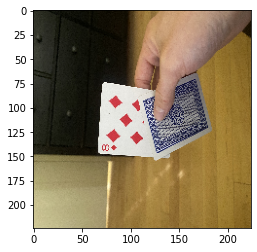

In [432]:
from keras.preprocessing import image
img_path  = "dataset_new_test/IMG_6895.jpg"
img = image.load_img(img_path, target_size=(img_width, img_height))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])


In [433]:
pred = model.predict(images, batch_size=10, verbose =1)


1/1 [==============================] - 2s 2s/step


In [434]:
print(classes_names[np.argmax(pred)])

8_diamonds


In [141]:
pred[0][np.argmax(pred)]

0.9711901